In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1
from matplotlib.patches import Wedge
import pandas as pd  # 导入 pandas 库

In [3]:
# 定义物理参数
c = 1500  # 声速，单位：m/s
rho0 = 1000  # 介质密度，单位：kg/m^3
f = 4e6  # 频率，单位：Hz
k = 2 * np.pi * f / c  # 波数
w = 2 * np.pi * f  # 角频率
u = 1  # 质点振动速度

In [ ]:
# 定义环形相控阵参数
m = 6  # 圆环个数
lambda_ = c / f  # 波长
R_max = 7.78e-3  # 中心阵元到最大辐射圆环中心的距离，单位：m
F = 10e-3  # 聚焦焦距，单位：m
Nmax = 15e-3 #近场临界ju
n = 0.7 #(m - 1) / m  # 圆环间距与波长的倍数系数
delta_d = n * lambda_  # 圆环之间的间距
# 定义 theta 范围
theta_values = np.linspace(-np.pi/2 , np.pi /2, 1000)

# 固定 r、phi 和 t 的值
r = F  # 可根据需要调整 r 的值
phi = 0
t = 0

In [5]:
all_data = []  # 用于存储所有 m 值对应的圆环阵列数据
mainlobe_avg_list = []
sidelobe_avg_list = []
Ri_list = np.zeros(m)
Ro_list = np.zeros(m)
a1_list = []  # 存储每个圆环的a1值
a2_list = []  # 存储每个圆环的a2值

In [6]:
# 定义 theta 范围
theta_values = np.linspace(-np.pi/2 , np.pi /2, 1000)

In [7]:
def save_annular_array_parameters(m,a1_list,a2_list):
    data = {
        'm值': [m] * m,  # 添加 m 值列
        '环编号': [i + 1 for i in range(m)],
        '内径 (mm)': [f'{a1*1000:.6f}' for a1 in a1_list],
        '外径 (mm)': [f'{a2*1000:.6f}' for a2 in a2_list]
    }
    df = pd.DataFrame(data)
    all_data.append(df)

    # 合并所有 DataFrame
    combined_df = pd.concat(all_data, ignore_index=True)

    # 保存到同一个 CSV 文件
    csv_file_path = 'annular_array_parameters_all.csv'
    combined_df.to_csv(csv_file_path, index=False)
    # print(f"所有 m 值对应的圆环阵列参数已保存到 {csv_file_path}")


In [8]:
# 封装计算等宽圆环内外径的代码为函数
def calculate_annular_radii(R_max, m, delta_d):
    a1_list = []  # 存储每个圆环的a1值
    a2_list = []  # 存储每个圆环的a2值    
    avgW = (R_max - (m - 1)*delta_d) / m
    for i in range(m):
        if i == 0:
            a1 = 0
        else:
            a1 = a2_list[i - 1] + delta_d
        a2 = a1 + avgW
        a2_list.append(a2)
        a1_list.append(a1)
    # save_annular_array_parameters(m,a1_list,a2_list)
    return a1_list, a2_list

In [9]:
# 封装计算等宽圆环内外径的代码为函数
def calculate_annular_radii_w(we, m, delta_d):
    a1_list = []  # 存储每个圆环的a1值
    a2_list = []  # 存储每个圆环的a2值     
    for i in range(m):
        if i == 0:
            a1 = 0
        else:
            a1 = a2_list[i - 1] + delta_d
        a2 = a1 + we
        a2_list.append(a2)
        a1_list.append(a1)
    # save_annular_array_parameters(m)
    return a1_list, a2_list

In [10]:
# 定义颜色列表
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

In [11]:
# 封装绘制圆环阵列的代码为函数
def plot_annular_array(inner_radii, outer_radii, max_diameter, gap, colors):
    print("Gap:%.2f[λ]"%(gap/lambda_))
    fig, ax = plt.subplots()
    fig.set_dpi(200)
    for i, (a1, a2) in enumerate(zip(inner_radii, outer_radii)):
        # 使用 Wedge 绘制中间有填充的环形
        ring = Wedge((0, 0), a2, 0, 360, width=(a2 - a1))
        # 从颜色列表中选取颜色进行填充
        color = colors[i % len(colors)]
        ring.set_facecolor(color)
        ring.set_edgecolor(color)
        ax.add_artist(ring)

        # 计算圆环面积
        area = np.pi * (a2**2 - a1**2)*1e6
        # 确定标注位置（圆环中心角度位置）
        label_r = (a1 + a2) / 2
        label_theta = 45  # 角度可以根据需要调整
        label_x = label_r * np.cos(np.radians(label_theta))
        label_y = label_r * np.sin(np.radians(label_theta))
        # 显示面积标注
        ax.text(label_x, label_y, f'area:{area:.2f}mm2', ha='center', va='center', color='black', fontsize=6)

    ax.set_xlim(-max_diameter  * 1.5, max_diameter  * 1.5)
    ax.set_ylim(-max_diameter  * 1.5, max_diameter  * 1.5)
    ax.set_aspect('equal')
    ax.set_title('Annular Array')
    plt.show()

Gap:0.70[λ]


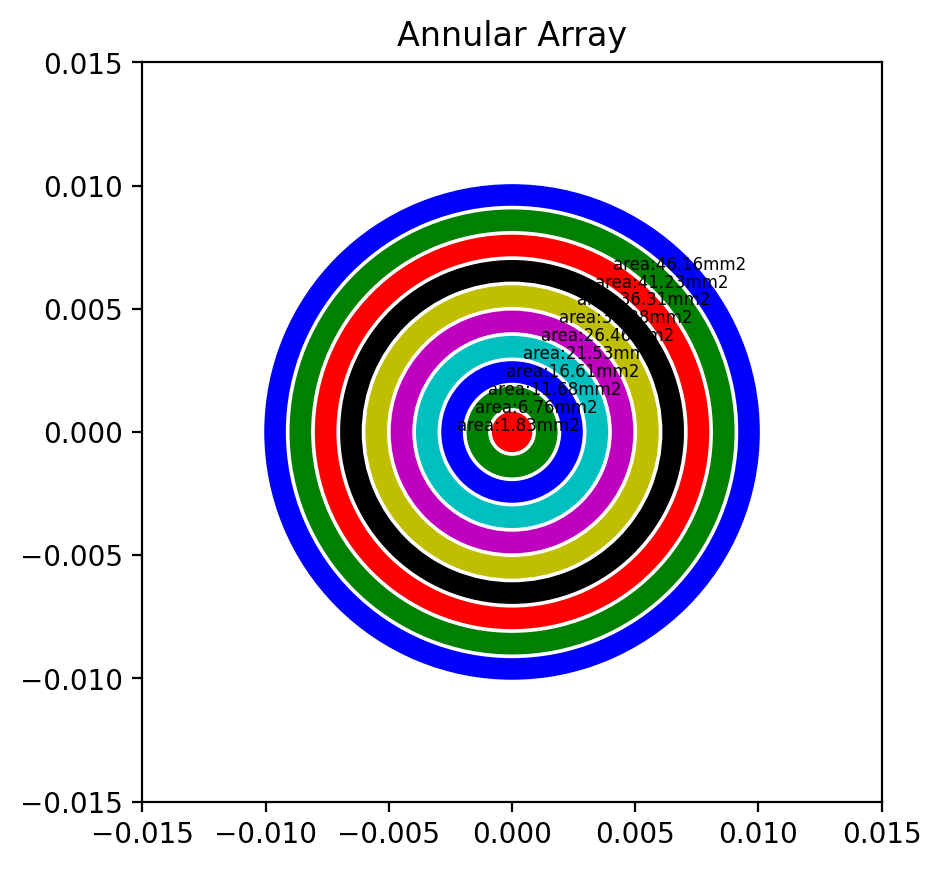

In [12]:
Ri_list, Ro_list = calculate_annular_radii(R_max,m,delta_d)
# 调用函数绘制圆环阵列
plot_annular_array(Ri_list, Ro_list, R_max, delta_d, colors)

In [13]:
# 定义声压公式，考虑分母为 0 的情况
def annular_array_pressure(a1_list,a2_list, F, r, m, theta, phi, t):
    p_total = 0
    epsilon = 1e-20  # 一个极小值，用于避免分母为 0
    Rm_max = 2/3*(a2_list[m-1]**3 - a2_list[m-2]**3)/(a2_list[m-1]**2-a2_list[m-2]**2)
    for i in range(m):
        a1 = a1_list[i]
        a2 = a2_list[i]
        R_m = 2/3*(a2**3 - a1**3)/(a2**2-a1**2)
        
        t_m = (np.sqrt(Rm_max ** 2 + F ** 2) - F - (np.sqrt(R_m ** 2 + F ** 2) - F)) / c
        denominator1 = k * a2 * np.cos(phi) * np.sin(theta)
        denominator2 = k * a1 * np.cos(phi) * np.sin(theta)

        # 计算 term1
        if np.abs(denominator1) < epsilon:
            # 当分母接近 0 时，使用贝塞尔函数极限性质
            term1 = a2 / 2
        else:
            term1 = (a2 ** 2 * j1(k * a2 * np.cos(phi) * np.sin(theta))) / denominator1

        # 计算 term2
        if np.abs(denominator2) < epsilon:
            # 当分母接近 0 时，使用贝塞尔函数极限性质
            term2 = a1 / 2
        else:
            term2 = (a1 ** 2 * j1(k * a1 * np.cos(phi) * np.sin(theta))) / denominator2

        p = (1j * k * rho0 * c * u / r) * (term1 - term2) * np.exp(1j * (2 * np.pi * f * t_m - k * r))
        p_total += p
    return p_total

In [14]:
# 定义评价声压旁瓣和主瓣的平均函数
def evaluate_sidelobe_mainlobe(pressure_values):
    # 找到最大声压值及其索引
    num = len(pressure_values)
    max_pressure = max(pressure_values)
    max_index = pressure_values.index(max_pressure)
    # print("Mid num:",num/2, "max index:",max_index)

    if max_index < num / 2:
        max_index = int(num / 2)

    # 简单假设主瓣是最大声压值左右各 5 个点的范围，可根据实际情况调整
    mainlobe_start = max(0, max_index - 5)
    mainlobe_end = min(len(pressure_values), max_index + 5)

    # 计算主瓣的平均声压
    mainlobe_pressures = pressure_values[mainlobe_start:mainlobe_end]
    mainlobe_avg = np.mean(mainlobe_pressures)

    # 找出所有峰值点
    peaks = []
    for i in range(1, len(pressure_values) - 1):
        if pressure_values[i] > pressure_values[i - 1] and pressure_values[i] > pressure_values[i + 1]:
            peaks.append(pressure_values[i])

    # 排除主瓣范围内的峰值
    sidelobe_peaks = []
    for peak in peaks:
        peak_index = pressure_values.index(peak)
        if peak_index < mainlobe_start or peak_index >= mainlobe_end:
            sidelobe_peaks.append(peak)

    # 计算旁瓣平均声压
    sidelobe_avg = np.mean(sidelobe_peaks) if sidelobe_peaks else 0


    return mainlobe_avg, sidelobe_avg

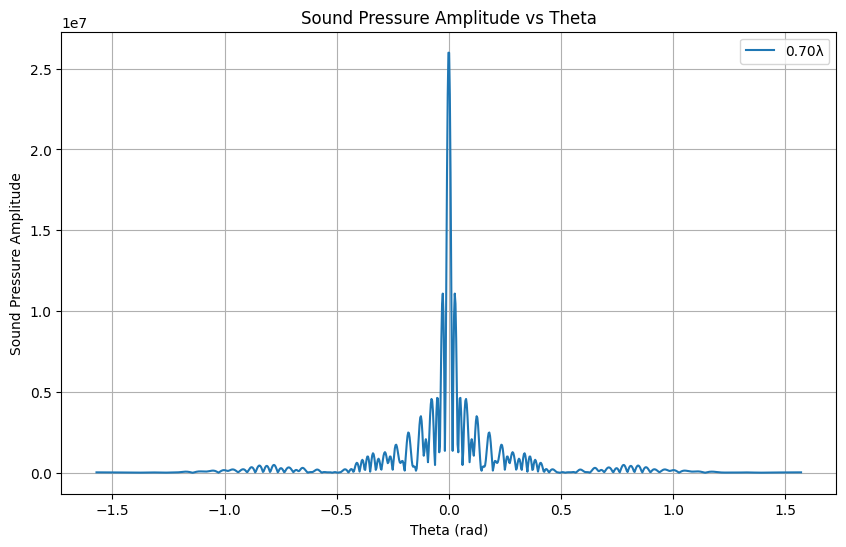

主瓣平均声压: 17121120.988222
旁瓣平均声压: 1120277.269138


In [15]:
plt.figure(figsize=(10, 6))   

# 计算每个 theta 对应的声压幅值
pressure_values = []
for theta in theta_values:
    pressure = annular_array_pressure(Ri_list,Ro_list, F, r, m, theta, phi, t)
    pressure_amplitude = np.abs(pressure)
    pressure_values.append(pressure_amplitude)
    # 绘制声压随 theta 的变化曲线    
plt.plot(theta_values, pressure_values,label='%.2fλ'%n)
plt.xlabel('Theta (rad)')
plt.ylabel('Sound Pressure Amplitude')
plt.title('Sound Pressure Amplitude vs Theta')
plt.legend()
plt.grid(True)
plt.show()    

# 调用评价函数
mainlobe_avg, sidelobe_avg = evaluate_sidelobe_mainlobe(pressure_values)
print(f"主瓣平均声压: {mainlobe_avg:.6f}")
print(f"旁瓣平均声压: {sidelobe_avg:.6f}")

In [60]:
from scipy.signal import find_peaks

def find_all_peaks(pressure_values):
    """
    寻找压力值列表中的所有峰值。

    参数:
    pressure_values (list): 包含压力值的列表。

    返回:
    list: 包含所有峰值的列表。
    """
    peaks, _ = find_peaks(pressure_values)
    return [pressure_values[i] for i in peaks]

def Sound_Pressure_delta(m, F, r, R_max, delta_d, theta, phi, t):
    # 定义 theta 范围
    theta_values = np.linspace(-np.pi/2 , np.pi /2, 1000)

    # 定义 delta_d 数组，范围从 0.1 * lambda_ 到 2 * lambda_
    delta_d_array = np.linspace(0.4 * lambda_, 1 * lambda_, 5)
    
    Rin_list = np.zeros(m)
    Rout_list = np.zeros(m)
    mainlobe_avg_list = []
    sidelobe_avg_list = []

    # 开始绘制不同 delta_d 下的声压曲线
    plt.figure(figsize=(20, 6))
    # 设置图片清晰度
    plt.rcParams['figure.dpi'] = 100

    for del_d in delta_d_array:
        # 调用函数计算圆环内外径
        Rin_list, Rout_list = calculate_annular_radii(R_max, m, del_d)
        # 调用函数绘制圆环阵列
        # plot_annular_array(Rin_list, Rout_list, R_max, delta_d, colors)
        # 计算每个 theta 对应的声压幅值
        pressure_values = []
        for the_ta in theta_values:
            pressure = annular_array_pressure(Rin_list,Rout_list,F, r, m, the_ta, phi, t)
            pressure_amplitude = np.abs(pressure)
            pressure_values.append(pressure_amplitude)
        # 将 theta 从弧度转换为角度
        theta_values_deg = np.rad2deg(theta_values)
        # 绘制声压随 theta（角度）的变化曲线
        plt.plot(theta_values_deg, pressure_values, label='{:.2f}λ'.format(del_d/lambda_))
        
        # 找出所有峰值
        peak_values = find_all_peaks(pressure_values)
        
        if len(peak_values) >= 2:
            # 对峰值进行排序
            sorted_peak_indices = np.argsort(peak_values)
            second_max_peak_index = sorted_peak_indices[-2]
            second_max_peak_original_index = np.where(np.array(pressure_values) == peak_values[second_max_peak_index])[0][0]
            
            # 找出最大值
            max_index = np.argmax(pressure_values)
            
            # 打印信息
            print(f"最大值索引: {theta_values_deg[max_index]}", f"最大值: {pressure_values[max_index]:.2e}")
            print(f"第二大峰值索引: {theta_values_deg[second_max_peak_original_index]}", f"第二大峰值: {pressure_values[second_max_peak_original_index]:.2e}")
            
            # 标记最大值和第二大峰值
            plt.text(theta_values_deg[max_index], pressure_values[max_index], f'Max: {max_index:.2e}', ha='center', va='bottom')
            plt.text(theta_values_deg[second_max_peak_original_index], pressure_values[second_max_peak_original_index], f'Second : {second_max_peak_original_index:.2e}', ha='center', va='bottom')
        
        # 调用评价函数
        mainlobe_avg, sidelobe_avg = evaluate_sidelobe_mainlobe(pressure_values)
        mainlobe_avg_list.append(mainlobe_avg)
        sidelobe_avg_list.append(sidelobe_avg)
        #print(f"主瓣平均声压: {mainlobe_avg:.6f}")
        #print(f"旁瓣平均声压: {sidelobe_avg:.6f}")
        
    plt.xlabel('Theta (rad)')
    plt.ylabel('Sound Pressure Amplitude')
    plt.title('Sound Pressure Amplitude vs Theta')
    plt.legend()
    plt.grid(True)
    plt.show() 

""" 
    # 绘制主瓣平均声压柱状图
    x_pos = np.arange(len(delta_d_array))
    x_data = [f'{v:.3f}' for v in delta_d_array / lambda_]

    fig,ax1 = plt.subplots()
    fig.set_size_inches(20, 6)
    ax1.set_xticks(x_pos, x_data)

    ax1.plot(x_pos, mainlobe_avg_list,color='red')
    for i, v in enumerate(mainlobe_avg_list):
        ax1.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')
    ax1.set_xlabel('delta_d(λ)')
    ax1.set_ylabel('Mainlobe Average Sound Pressure')
    ax1.legend('Mainlobe')
    # plt.xlabel('delta_d')
    # plt.title('Mainlobe Average Sound Pressure')    
    # 显示图表
    # plt.show()
        
    # plt.figure(figsize=(20, 6))    
    # plt.xticks(x_pos, x_data)
    ax2 = ax1.twinx()
    ax2.plot(x_pos, sidelobe_avg_list,color='blue')
    ax2.set_ylabel('Sidelobe Average Sound Pressure')
    for i, v in enumerate(sidelobe_avg_list):
        ax2.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')
    ax2.legend('Sidelobe')    
    # plt.xlabel('delta_d')
    # plt.title('Sidelobe Average Sound Pressure')
    # 显示图表
    plt.show() """

" \n    # 绘制主瓣平均声压柱状图\n    x_pos = np.arange(len(delta_d_array))\n    x_data = [f'{v:.3f}' for v in delta_d_array / lambda_]\n\n    fig,ax1 = plt.subplots()\n    fig.set_size_inches(20, 6)\n    ax1.set_xticks(x_pos, x_data)\n\n    ax1.plot(x_pos, mainlobe_avg_list,color='red')\n    for i, v in enumerate(mainlobe_avg_list):\n        ax1.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')\n    ax1.set_xlabel('delta_d(λ)')\n    ax1.set_ylabel('Mainlobe Average Sound Pressure')\n    ax1.legend('Mainlobe')\n    # plt.xlabel('delta_d')\n    # plt.title('Mainlobe Average Sound Pressure')    \n    # 显示图表\n    # plt.show()\n        \n    # plt.figure(figsize=(20, 6))    \n    # plt.xticks(x_pos, x_data)\n    ax2 = ax1.twinx()\n    ax2.plot(x_pos, sidelobe_avg_list,color='blue')\n    ax2.set_ylabel('Sidelobe Average Sound Pressure')\n    for i, v in enumerate(sidelobe_avg_list):\n        ax2.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')\n    ax2.legend('Sidelobe')    \n    # plt.xl

Fc =  0.01 rc =  0.01 Rm =  0.007 ns =  6
最大值索引: 0.09009009009008323 最大值: 2.87e+07
第二大峰值索引: -6.756756756756763 第二大峰值: 8.16e+06
最大值索引: 0.09009009009008323 最大值: 2.79e+07
第二大峰值索引: -6.756756756756763 第二大峰值: 7.71e+06
最大值索引: 0.09009009009008323 最大值: 2.66e+07
第二大峰值索引: -6.756756756756763 第二大峰值: 7.18e+06
最大值索引: 0.09009009009008323 最大值: 2.50e+07
第二大峰值索引: 6.756756756756751 第二大峰值: 6.58e+06
最大值索引: 0.09009009009008323 最大值: 2.31e+07
第二大峰值索引: 6.756756756756751 第二大峰值: 5.95e+06


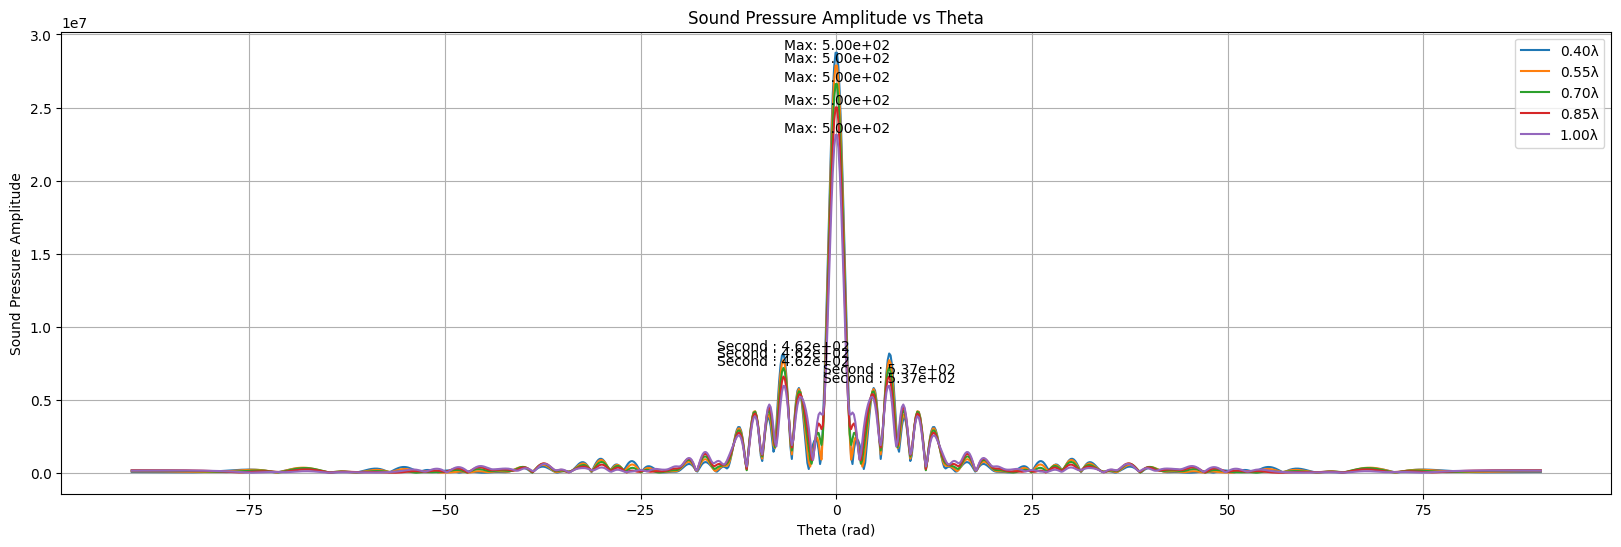


Fc =  0.015 rc =  0.015 Rm =  0.007 ns =  6
最大值索引: 0.09009009009008323 最大值: 2.44e+07
第二大峰值索引: 2.4324324324324254 第二大峰值: 8.26e+06
最大值索引: 0.09009009009008323 最大值: 2.31e+07
第二大峰值索引: 2.4324324324324254 第二大峰值: 7.85e+06
最大值索引: 0.09009009009008323 最大值: 2.17e+07
第二大峰值索引: 2.4324324324324254 第二大峰值: 7.41e+06
最大值索引: 0.09009009009008323 最大值: 2.03e+07
第二大峰值索引: 2.4324324324324254 第二大峰值: 6.95e+06
最大值索引: 0.09009009009008323 最大值: 1.88e+07
第二大峰值索引: 2.4324324324324254 第二大峰值: 6.47e+06


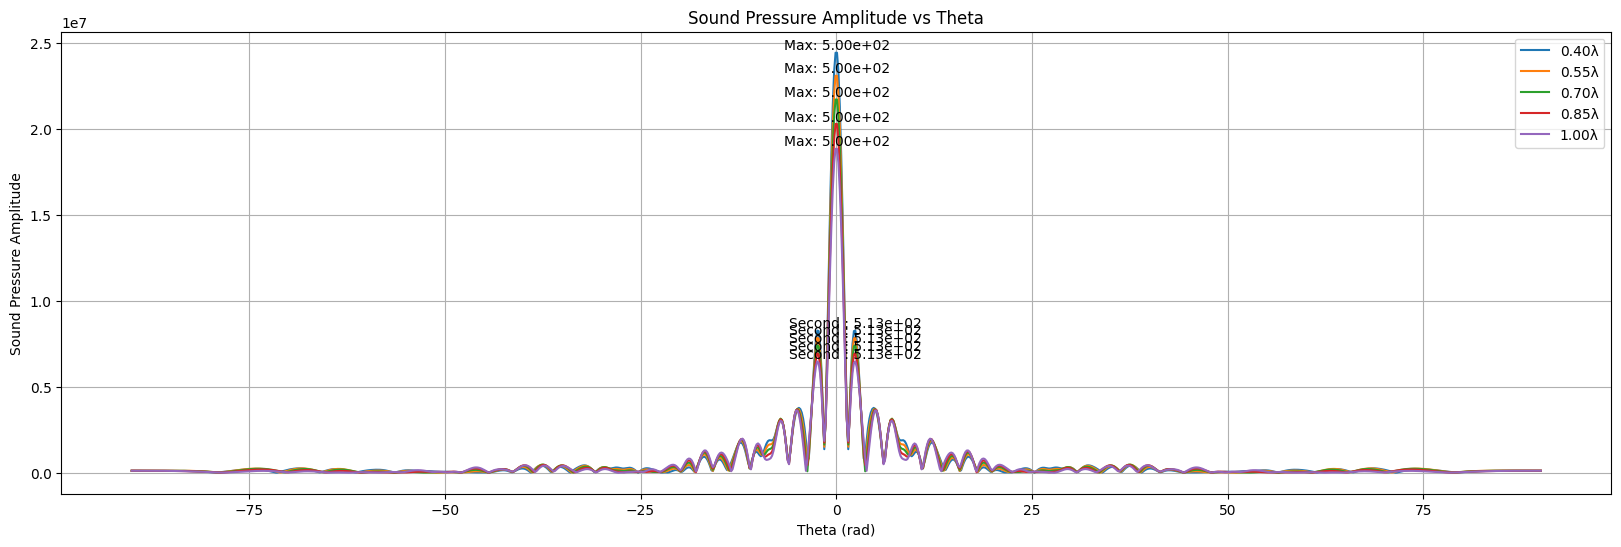


Fc =  0.019999999999999997 rc =  0.019999999999999997 Rm =  0.007 ns =  6
最大值索引: 0.09009009009008323 最大值: 1.11e+07
第二大峰值索引: -2.0720720720720798 第二大峰值: 6.27e+06
最大值索引: 0.09009009009008323 最大值: 1.10e+07
第二大峰值索引: 2.072072072072067 第二大峰值: 6.06e+06
最大值索引: 0.09009009009008323 最大值: 1.09e+07
第二大峰值索引: -2.0720720720720798 第二大峰值: 5.83e+06
最大值索引: 0.09009009009008323 最大值: 1.08e+07
第二大峰值索引: -2.0720720720720798 第二大峰值: 5.59e+06
最大值索引: 0.09009009009008323 最大值: 1.06e+07
第二大峰值索引: 2.072072072072067 第二大峰值: 5.33e+06


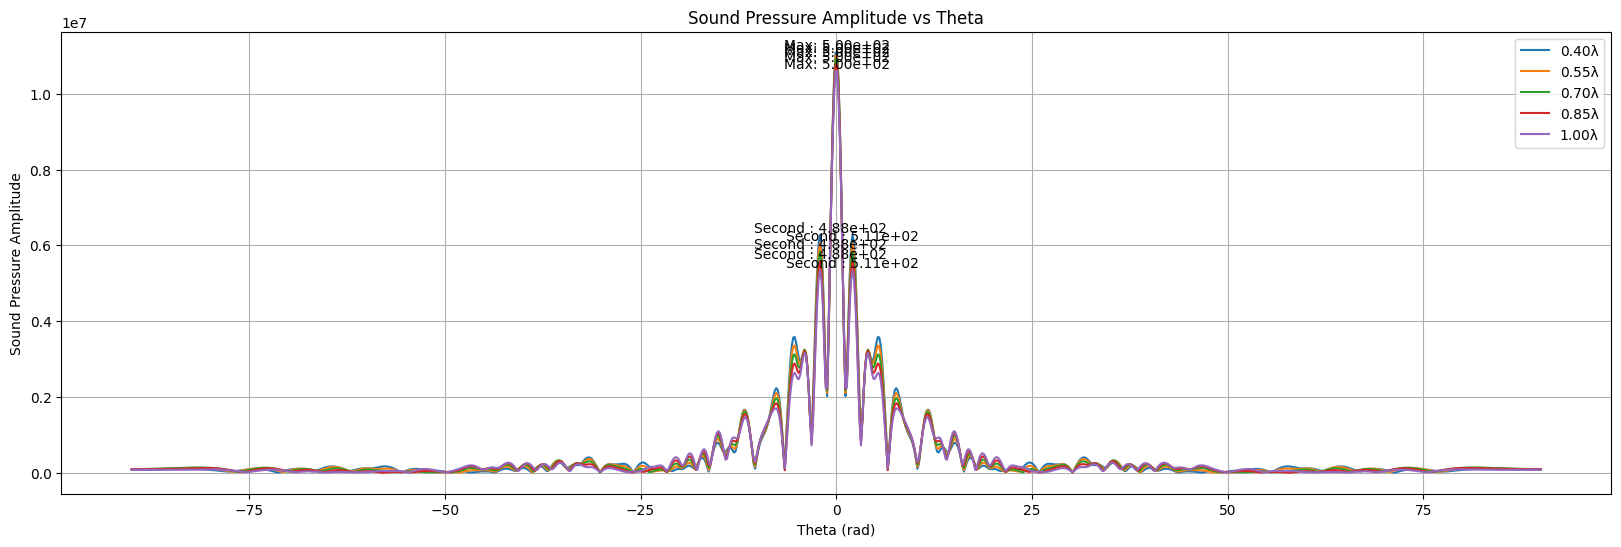


Fc =  0.024999999999999998 rc =  0.024999999999999998 Rm =  0.007 ns =  6
最大值索引: 0.09009009009008323 最大值: 7.23e+06
第二大峰值索引: -3.513513513513513 第二大峰值: 3.17e+06
最大值索引: 0.09009009009008323 最大值: 7.02e+06
第二大峰值索引: -3.513513513513513 第二大峰值: 3.03e+06
最大值索引: 0.09009009009008323 最大值: 6.79e+06
第二大峰值索引: -3.513513513513513 第二大峰值: 2.89e+06
最大值索引: 0.09009009009008323 最大值: 6.55e+06
第二大峰值索引: -3.513513513513513 第二大峰值: 2.73e+06
最大值索引: 0.09009009009008323 最大值: 6.30e+06
第二大峰值索引: -5.495495495495496 第二大峰值: 2.61e+06


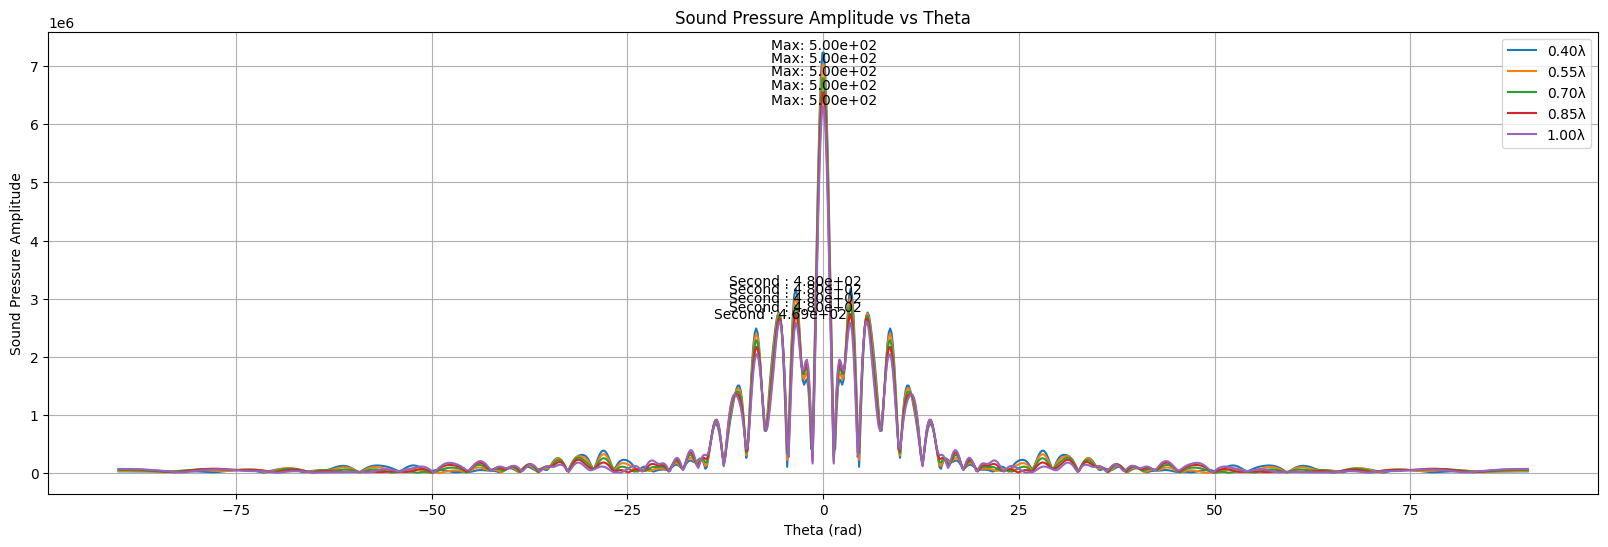


Fc =  0.03 rc =  0.03 Rm =  0.007 ns =  6
最大值索引: 0.09009009009008323 最大值: 3.23e+06
第二大峰值索引: -6.576576576576584 第二大峰值: 2.37e+06
最大值索引: 0.09009009009008323 最大值: 3.26e+06
第二大峰值索引: 6.576576576576572 第二大峰值: 2.30e+06
最大值索引: 0.09009009009008323 最大值: 3.28e+06
第二大峰值索引: -8.558558558558568 第二大峰值: 2.26e+06
最大值索引: 0.09009009009008323 最大值: 3.29e+06
第二大峰值索引: 8.558558558558556 第二大峰值: 2.21e+06
最大值索引: 0.09009009009008323 最大值: 3.28e+06
第二大峰值索引: 8.558558558558556 第二大峰值: 2.15e+06


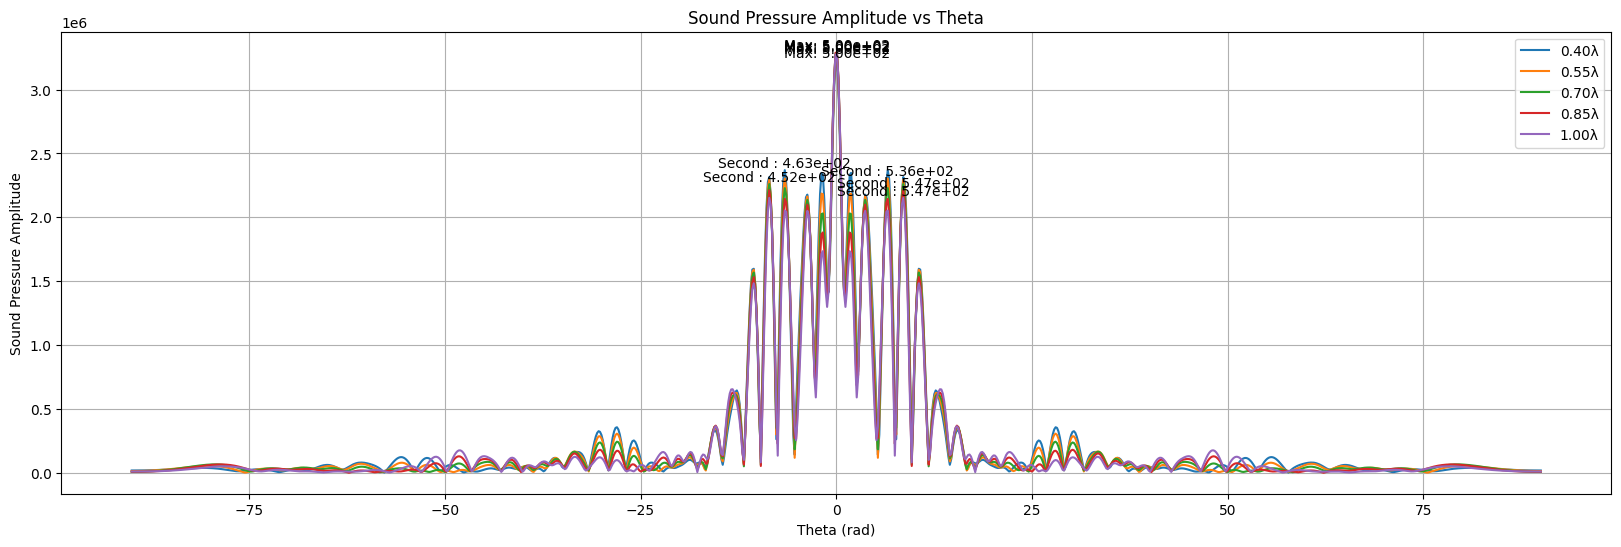

" for i in range(len(Fc)):\n    for j in range(len(rc)):\n        print('Fc = ',Fc[i],'rc = ',rc[j],'Rm = ',Rm, 'ns = ', ns[0])\n        Sound_Pressure_delta(m=ns[0], F=Fc[i],r=rc[j],R_max=Rm,delta_d=None,theta=None,phi=0,t=0)\n        print('')  "

In [64]:
Fc = np.linspace(10e-3,30e-3,5)
rc = np.linspace(10e-3,30e-3,5)

Rm = np.linspace(7e-3,10e-3,1)
ns = np.arange(6,11,1)
for i in range(len(Fc)):
    for j in range(len(Rm)):
        print('Fc = ',Fc[i],'rc = ',Fc[i],'Rm = ',Rm[j], 'ns = ', ns[0])
        Sound_Pressure_delta(m=ns[0], F=Fc[i],r=Fc[i],R_max=Rm[j],delta_d=None,theta=None,phi=0,t=0)
        print('') 
            
""" for i in range(len(Fc)):
    for j in range(len(rc)):
        print('Fc = ',Fc[i],'rc = ',rc[j],'Rm = ',Rm, 'ns = ', ns[0])
        Sound_Pressure_delta(m=ns[0], F=Fc[i],r=rc[j],R_max=Rm,delta_d=None,theta=None,phi=0,t=0)
        print('')  """


主瓣平均声压: 1197190.601561
旁瓣平均声压: 382944.334329
主瓣平均声压: 1777752.339731
旁瓣平均声压: 524798.959001
主瓣平均声压: 2099945.641385
旁瓣平均声压: 663299.752531
主瓣平均声压: 7599088.409860
旁瓣平均声压: 944226.644097
主瓣平均声压: 18848883.253201
旁瓣平均声压: 1139328.416046
主瓣平均声压: 16679295.579442
旁瓣平均声压: 1162623.305130
主瓣平均声压: 19687419.822497
旁瓣平均声压: 1222090.991500
主瓣平均声压: 18680509.454812
旁瓣平均声压: 1795006.200185
主瓣平均声压: 7414640.333077
旁瓣平均声压: 1803613.103493
主瓣平均声压: 22519835.811715
旁瓣平均声压: 1900554.568647
主瓣平均声压: 55347199.735740
旁瓣平均声压: 1706556.275928
主瓣平均声压: 33117363.215444
旁瓣平均声压: 2093725.628440
主瓣平均声压: 30528852.415915
旁瓣平均声压: 1869788.176360
主瓣平均声压: 68723015.745811
旁瓣平均声压: 1762862.218775
主瓣平均声压: 57106303.194426
旁瓣平均声压: 2206965.664091
主瓣平均声压: 62533369.005055
旁瓣平均声压: 2416265.828285
主瓣平均声压: 76832772.086220
旁瓣平均声压: 2293497.505478
主瓣平均声压: 64648048.029421
旁瓣平均声压: 2703840.463223
主瓣平均声压: 83418638.798768
旁瓣平均声压: 2319777.713477
主瓣平均声压: 68546531.634647
旁瓣平均声压: 3000787.838322


<Figure size 1000x600 with 0 Axes>

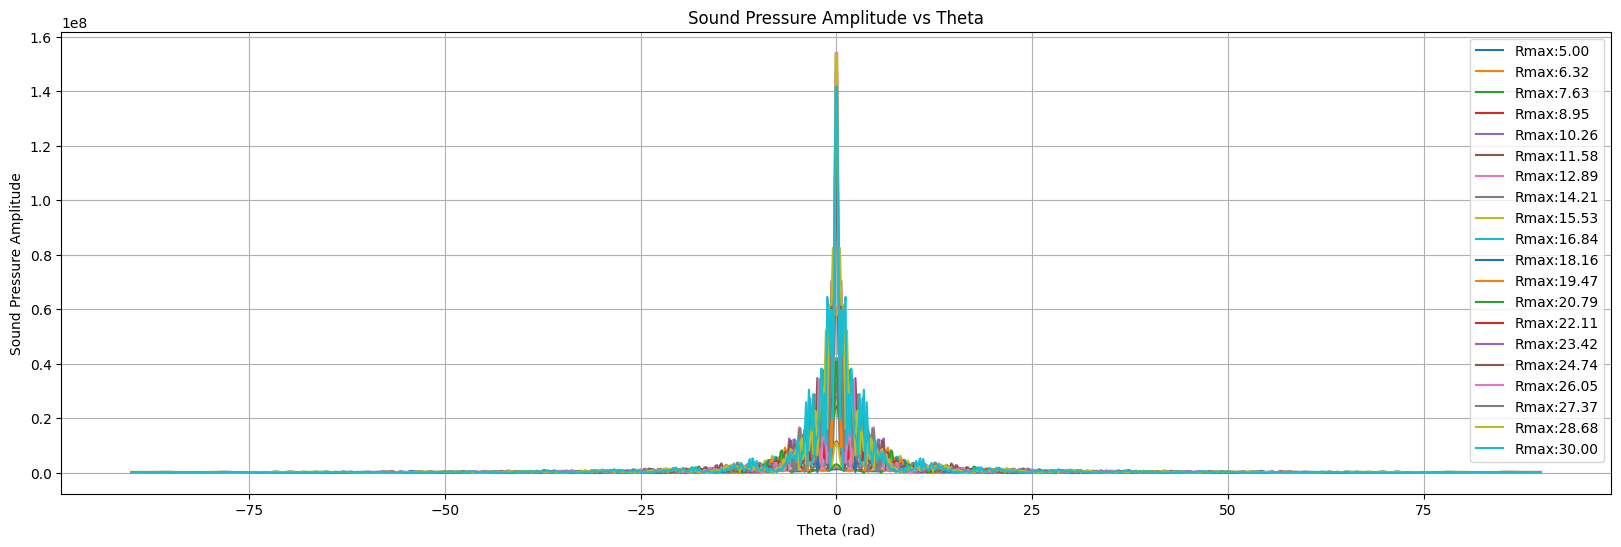

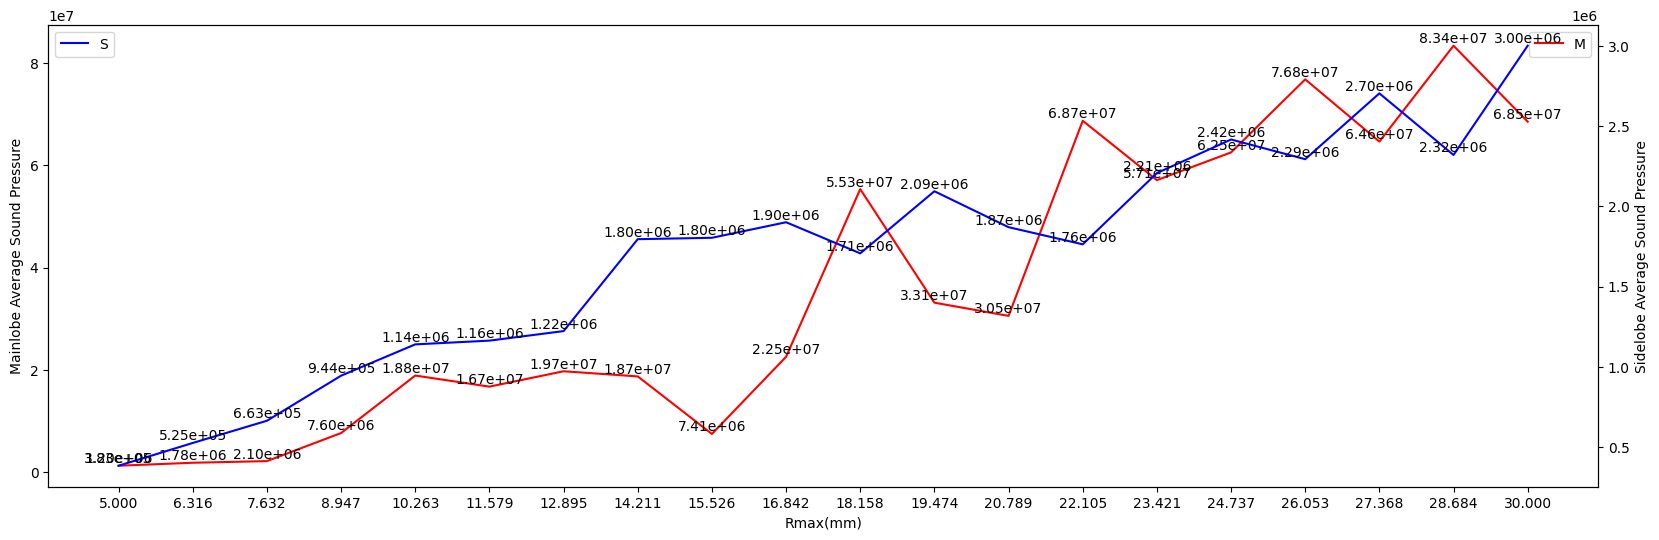

In [18]:
plt.figure(figsize=(10, 6))   

# 定义 delta_d 数组，范围从 0.1 * lambda_ 到 2 * lambda_
Rmax_d_array = np.linspace(5e-3, 30e-3, 20)

a1_list = []
a2_list = []
mainlobe_avg_list = []
sidelobe_avg_list = []

# 开始绘制不同 delta_d 下的声压曲线
plt.figure(figsize=(20, 6))
# 设置图片清晰度
plt.rcParams['figure.dpi'] = 100

for Rmax in Rmax_d_array:
    a1_list = []
    a2_list = []
    # 调用函数计算圆环内外径
    a1_list, a2_list = calculate_annular_radii(Rmax, m, delta_d)
    # 调用函数绘制圆环阵列
    # plot_annular_array(a1_list, a2_list, R_max, delta_d, colors)
    # 计算每个 theta 对应的声压幅值
    pressure_values = []
    for theta in theta_values:
        pressure = annular_array_pressure(a1_list,a2_list, F, r, m, theta, phi, t)
        pressure_amplitude = np.abs(pressure)
        pressure_values.append(pressure_amplitude)
    # 将 theta 从弧度转换为角度
    theta_values_deg = np.rad2deg(theta_values)
    # 绘制声压随 theta（角度）的变化曲线
    plt.plot(theta_values_deg, pressure_values, label='Rmax:{:.2f}'.format(Rmax*1e3))
    # 调用评价函数
    mainlobe_avg, sidelobe_avg = evaluate_sidelobe_mainlobe(pressure_values)
    mainlobe_avg_list.append(mainlobe_avg)
    sidelobe_avg_list.append(sidelobe_avg)
    print(f"主瓣平均声压: {mainlobe_avg:.6f}")
    print(f"旁瓣平均声压: {sidelobe_avg:.6f}")
plt.xlabel('Theta (rad)')
plt.ylabel('Sound Pressure Amplitude')
plt.title('Sound Pressure Amplitude vs Theta')
plt.legend()
plt.grid(True)
plt.show() 


# 绘制主瓣平均声压柱状图
x_pos = np.arange(len(Rmax_d_array))
x_data = [f'{v:.3f}' for v in Rmax_d_array*1e3]

fig,ax1 = plt.subplots()
fig.set_size_inches(20, 6)
ax1.set_xticks(x_pos, x_data)

ax2 = ax1.twinx()
ax1.plot(x_pos, mainlobe_avg_list,color='red')
for i, v in enumerate(mainlobe_avg_list):
    ax1.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')
ax1.set_xlabel('Rmax(mm)')
ax1.set_ylabel('Mainlobe Average Sound Pressure')
ax1.legend('Mainlobe')
# plt.xlabel('delta_d')
# plt.title('Mainlobe Average Sound Pressure')    
# 显示图表
# plt.show()
    
# plt.figure(figsize=(20, 6))    
# plt.xticks(x_pos, x_data)
ax2.plot(x_pos, sidelobe_avg_list,color='blue')
ax2.set_ylabel('Sidelobe Average Sound Pressure')
for i, v in enumerate(sidelobe_avg_list):
    ax2.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')
ax2.legend('Sidelobe')    
# plt.xlabel('delta_d')
# plt.title('Sidelobe Average Sound Pressure')
# 显示图表
plt.show()

主瓣平均声压: 2622489.973294
旁瓣平均声压: 1440123.709592
主瓣平均声压: 14715144.501080
旁瓣平均声压: 2911231.257349
主瓣平均声压: 15927286.291630
旁瓣平均声压: 3367785.125232
主瓣平均声压: 15559542.026325
旁瓣平均声压: 4421899.192578
主瓣平均声压: 18339721.710366
旁瓣平均声压: 4851534.417944
主瓣平均声压: 68690410.709473
旁瓣平均声压: 5108522.375392
主瓣平均声压: 57197187.206120
旁瓣平均声压: 6225142.918430
主瓣平均声压: 70364027.821786
旁瓣平均声压: 7252922.137839
主瓣平均声压: 112659288.940274
旁瓣平均声压: 7393437.121582
主瓣平均声压: 68935510.140963
旁瓣平均声压: 8961287.151039
主瓣平均声压: 204849365.598515
旁瓣平均声压: 8383437.321992
主瓣平均声压: 211180860.795228
旁瓣平均声压: 11305780.020004
主瓣平均声压: 187032601.452052
旁瓣平均声压: 10840639.940927
主瓣平均声压: 389076360.130158
旁瓣平均声压: 11462426.861991
主瓣平均声压: 97696302.688593
旁瓣平均声压: 14561886.197675
主瓣平均声压: 232442277.764554
旁瓣平均声压: 13898667.966806
主瓣平均声压: 268024801.946786
旁瓣平均声压: 11884028.935698
主瓣平均声压: 139118606.472571
旁瓣平均声压: 15842577.871235


<Figure size 2000x600 with 0 Axes>

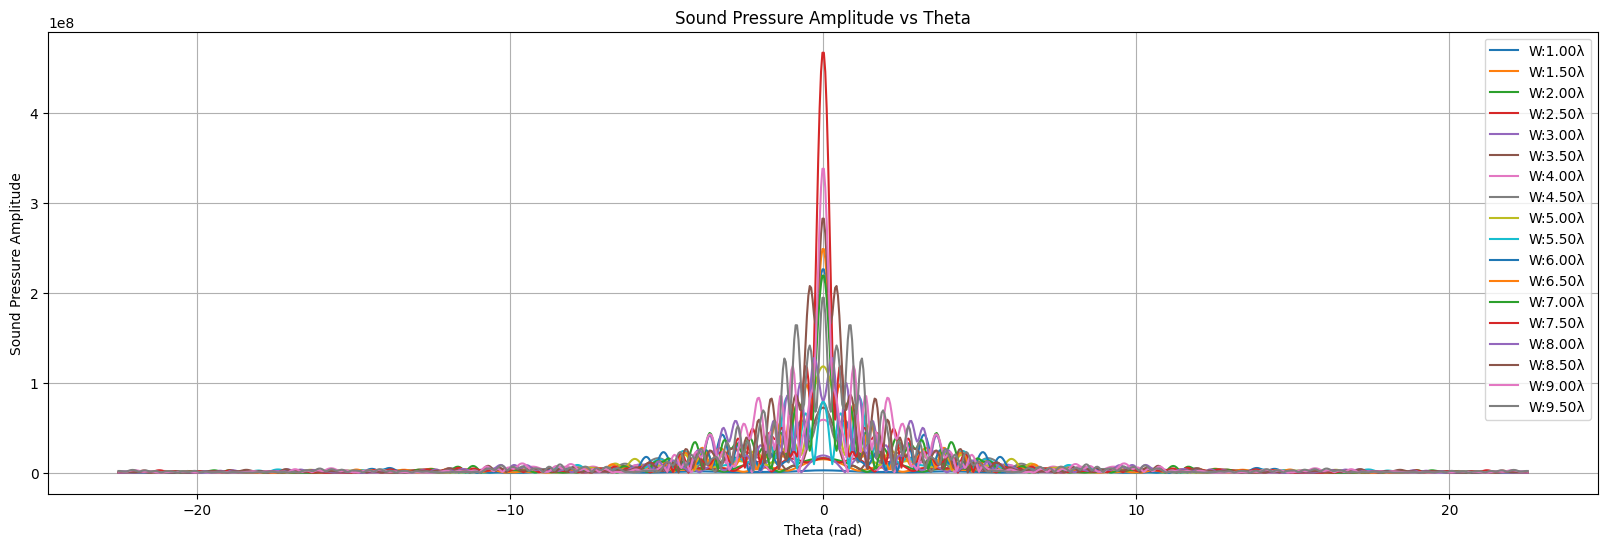

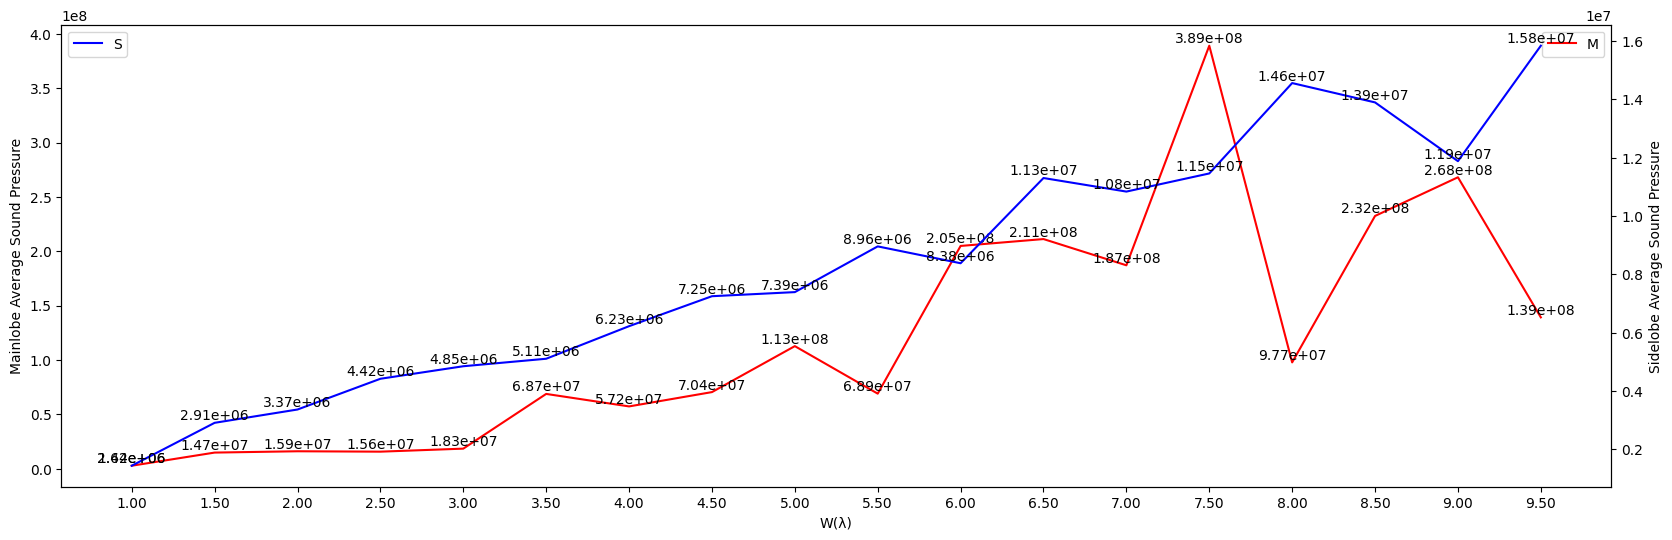

In [19]:
plt.figure(figsize=(20, 6))   

# 固定 r、phi 和 t 的值
F = 15e-3
r = F  # 可根据需要调整 r 的值
phi = 0
t = 0
pressure = 0

delta_d = lambda_ * 0.7
# 定义 delta_d 数组，范围从 0.1 * lambda_ 到 2 * lambda_
we_d_array = np.arange(lambda_  , lambda_  * 10, lambda_ * 0.5)

a1_list = []
a2_list = []
mainlobe_avg_list = []
sidelobe_avg_list = []

# 开始绘制不同 delta_d 下的声压曲线
plt.figure(figsize=(20, 6))
# 设置图片清晰度
plt.rcParams['figure.dpi'] = 100
# 定义 theta 范围
theta_values = np.linspace(-np.pi/8 , np.pi /8, 1000)

for we_d in we_d_array:
    a1_list = []
    a2_list = []
    # 调用函数计算圆环内外径
    a1_list, a2_list = calculate_annular_radii_w(we_d, m, delta_d)
    # 调用函数绘制圆环阵列
    # plot_annular_array(a1_list, a2_list, R_max, delta_d, colors)
    # 计算每个 theta 对应的声压幅值

    pressure_values = []
    for theta in theta_values:
        pressure = annular_array_pressure(a1_list,a2_list, F, r, m, theta, phi, t)
        pressure_amplitude = np.abs(pressure)
        pressure_values.append(pressure_amplitude)   
    # 将 theta 从弧度转换为角度
    theta_values_deg = np.rad2deg(theta_values)
    # 绘制声压随 theta（角度）的变化曲线
    plt.plot(theta_values_deg, pressure_values, label='W:{:.2f}λ'.format(we_d / lambda_))
    # 调用评价函数
    mainlobe_avg, sidelobe_avg = evaluate_sidelobe_mainlobe(pressure_values)
    mainlobe_avg_list.append(mainlobe_avg)
    sidelobe_avg_list.append(sidelobe_avg)
    print(f"主瓣平均声压: {mainlobe_avg:.6f}")
    print(f"旁瓣平均声压: {sidelobe_avg:.6f}")
plt.xlabel('Theta (rad)')
plt.ylabel('Sound Pressure Amplitude')
plt.title('Sound Pressure Amplitude vs Theta')
plt.legend()
plt.grid(True)
plt.show() 


# 绘制主瓣平均声压柱状图
x_pos = np.arange(len(we_d_array))
x_data = [f'{v:.2f}' for v in we_d_array / lambda_]

fig,ax1 = plt.subplots()
fig.set_size_inches(20, 6)
ax1.set_xticks(x_pos, x_data)

ax2 = ax1.twinx()
ax1.plot(x_pos, mainlobe_avg_list,color='red')
for i, v in enumerate(mainlobe_avg_list):
    ax1.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')
ax1.set_xlabel('W(λ)')
ax1.set_ylabel('Mainlobe Average Sound Pressure')
ax1.legend('Mainlobe')
# plt.xlabel('delta_d')
# plt.title('Mainlobe Average Sound Pressure')    
# 显示图表
# plt.show()
    
# plt.figure(figsize=(20, 6))    
# plt.xticks(x_pos, x_data)
ax2.plot(x_pos, sidelobe_avg_list,color='blue')
ax2.set_ylabel('Sidelobe Average Sound Pressure')
for i, v in enumerate(sidelobe_avg_list):
    ax2.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')
ax2.legend('Sidelobe')    
# plt.xlabel('delta_d')
# plt.title('Sidelobe Average Sound Pressure')
# 显示图表
plt.show()



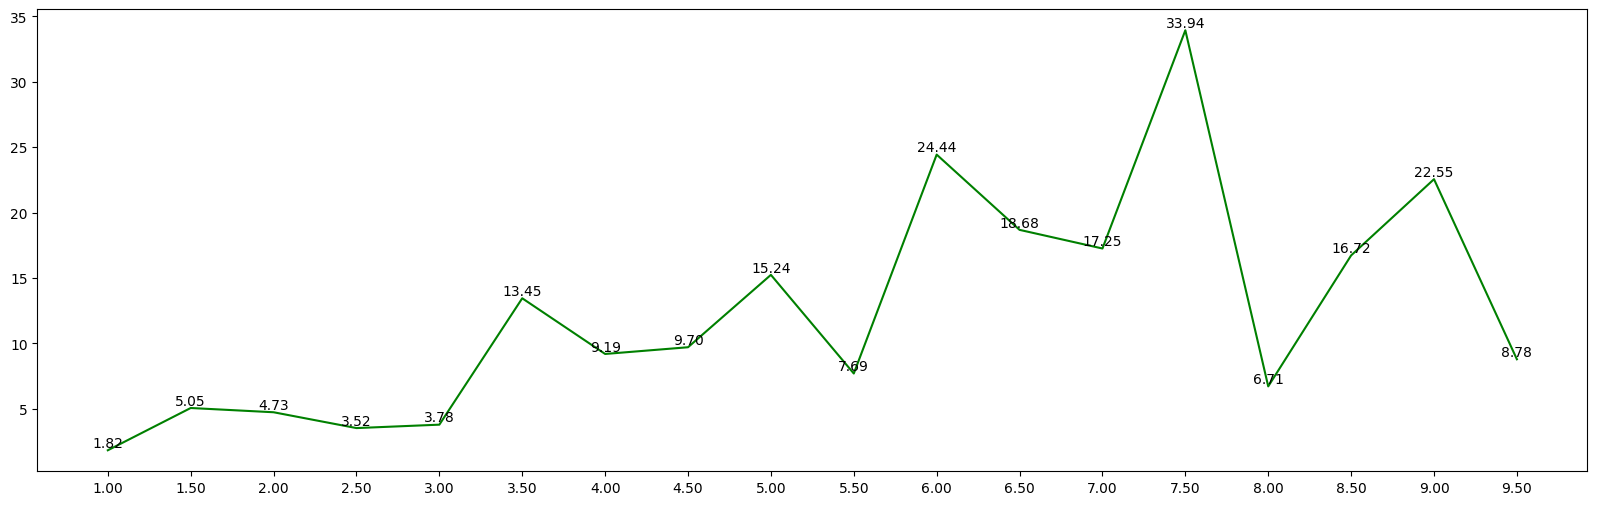

In [20]:
plt.figure(figsize=(20, 6))
plt.xticks(x_pos, x_data)
ratio = np.array(mainlobe_avg_list)/np.array(sidelobe_avg_list)
plt.plot(x_pos,ratio,color='green')
for i, v in enumerate(ratio):
    plt.text(x_pos[i], v, f'{v:.2f}', ha='center', va='bottom')
plt.show()

主瓣平均声压: 12732176268.247244
旁瓣平均声压: 106209281.311979
主瓣平均声压: 23765651081.128475
旁瓣平均声压: 89342818.400942
主瓣平均声压: 40808276728.838890
旁瓣平均声压: 93238785.797578
主瓣平均声压: 34289882412.626892
旁瓣平均声压: 102995678.034872
主瓣平均声压: 29750824176.983589
旁瓣平均声压: 116009406.813917
主瓣平均声压: 44720117092.518227
旁瓣平均声压: 149683021.317222
主瓣平均声压: 21247032253.077587
旁瓣平均声压: 155691933.239456
主瓣平均声压: 33256678739.475525
旁瓣平均声压: 84196874.795528
主瓣平均声压: 68131112934.896103
旁瓣平均声压: 140474739.885187
主瓣平均声压: 51643481179.753624
旁瓣平均声压: 158109022.942962
主瓣平均声压: 42560152755.958878
旁瓣平均声压: 171898284.134636
主瓣平均声压: 57304712660.612320
旁瓣平均声压: 106690858.120123
主瓣平均声压: 46938793169.956146
旁瓣平均声压: 150261139.695273
主瓣平均声压: 102731511467.329865
旁瓣平均声压: 156895088.690671


<Figure size 1000x600 with 0 Axes>

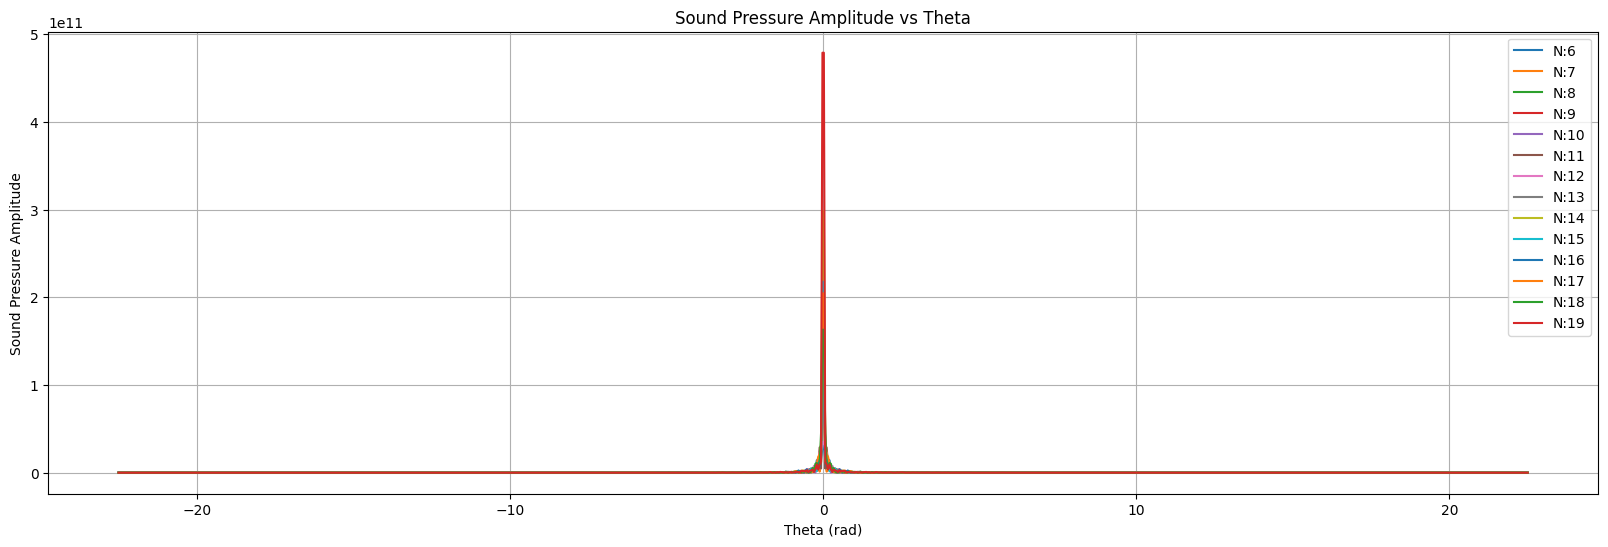

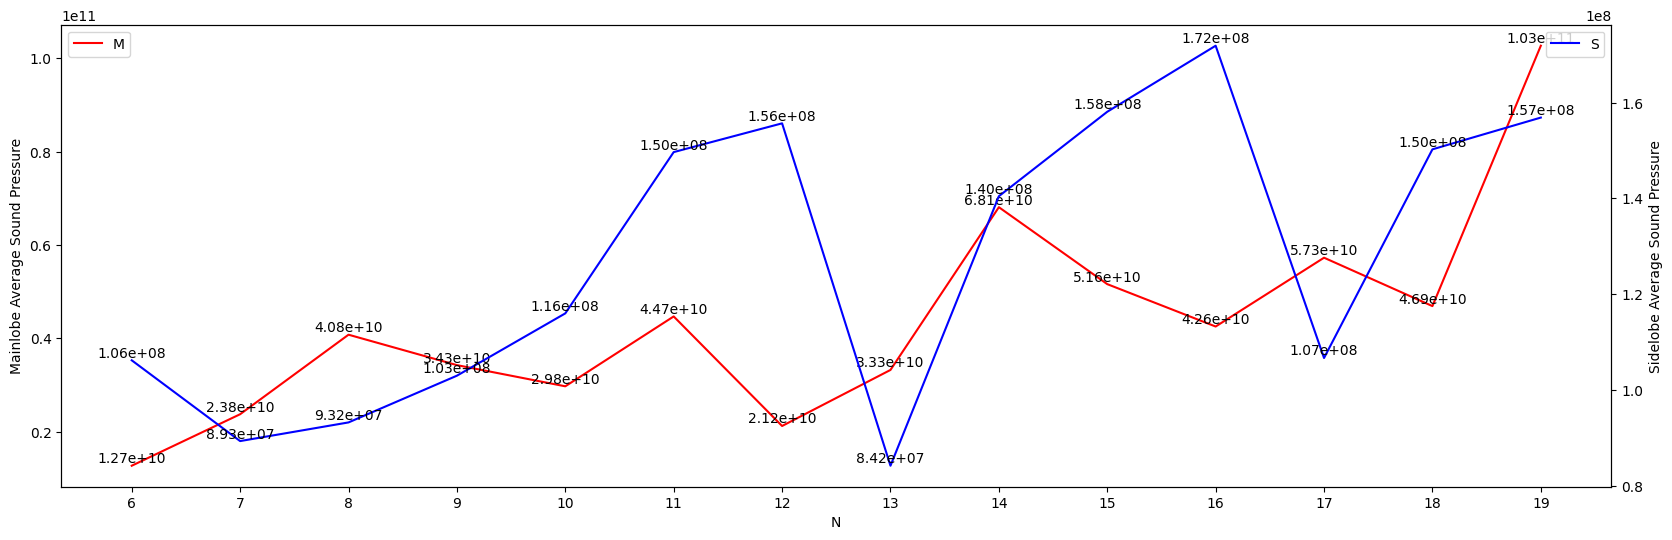

In [21]:
plt.figure(figsize=(10, 6))   

# 固定 r、phi 和 t 的值
r = F  # 可根据需要调整 r 的值
phi = 0
t = 0
pressure = 0
R_max = 25e-3
# 定义 delta_d 数组，范围从 0.1 * lambda_ 到 2 * lambda_
n_d_array = np.arange(6, 20, 1)

a1_list = []
a2_list = []
mainlobe_avg_list = []
sidelobe_avg_list = []

# 开始绘制不同 delta_d 下的声压曲线
plt.figure(figsize=(20, 6))
# 设置图片清晰度
plt.rcParams['figure.dpi'] = 100

for n_d in n_d_array:
    a1_list = []
    a2_list = []
    # 调用函数计算圆环内外径
    delta_d = (n_d - 1) / n_d
    a1_list, a2_list = calculate_annular_radii(R_max, n_d, delta_d)
    # 调用函数绘制圆环阵列
    # plot_annular_array(a1_list, a2_list, R_max, delta_d, colors)
    # 计算每个 theta 对应的声压幅值

    pressure_values = []
    for theta in theta_values:
        pressure = annular_array_pressure(a1_list, a2_list, F, r, n_d, theta, phi, t)
        pressure_amplitude = np.abs(pressure)
        pressure_values.append(pressure_amplitude)   
    # 将 theta 从弧度转换为角度
    theta_values_deg = np.rad2deg(theta_values)
    # 绘制声压随 theta（角度）的变化曲线
    plt.plot(theta_values_deg, pressure_values, label='N:{:d}'.format(n_d))
    # 调用评价函数
    mainlobe_avg, sidelobe_avg = evaluate_sidelobe_mainlobe(pressure_values)
    mainlobe_avg_list.append(mainlobe_avg)
    sidelobe_avg_list.append(sidelobe_avg)
    print(f"主瓣平均声压: {mainlobe_avg:.6f}")
    print(f"旁瓣平均声压: {sidelobe_avg:.6f}")
plt.xlabel('Theta (rad)')
plt.ylabel('Sound Pressure Amplitude')
plt.title('Sound Pressure Amplitude vs Theta')
plt.legend()
plt.grid(True)
plt.show() 


# 绘制主瓣平均声压柱状图
x_pos = np.arange(len(n_d_array))
x_data = [f'{v:d}' for v in n_d_array]

fig,ax1 = plt.subplots()
fig.set_size_inches(20, 6)
ax1.set_xticks(x_pos, x_data)

ax2 = ax1.twinx()
ax1.plot(x_pos, mainlobe_avg_list,color='red')
for i, v in enumerate(mainlobe_avg_list):
    ax1.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')
ax1.set_xlabel('N')
ax1.set_ylabel('Mainlobe Average Sound Pressure')
ax1.legend('Mainlobe')
# plt.xlabel('delta_d')
# plt.title('Mainlobe Average Sound Pressure')    
# 显示图表
# plt.show()
    
# plt.figure(figsize=(20, 6))    
# plt.xticks(x_pos, x_data)
ax2.plot(x_pos, sidelobe_avg_list,color='blue')
ax2.set_ylabel('Sidelobe Average Sound Pressure')
for i, v in enumerate(sidelobe_avg_list):
    ax2.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')
ax2.legend('Sidelobe')    
# plt.xlabel('delta_d')
# plt.title('Sidelobe Average Sound Pressure')
# 显示图表
plt.show()



主瓣平均声压: 71563609685.767563
旁瓣平均声压: 126998516.422795
主瓣平均声压: 64785691588.109520
旁瓣平均声压: 104632759.237471
主瓣平均声压: 59189137239.202805
旁瓣平均声压: 110667668.687623
主瓣平均声压: 54506561074.417213
旁瓣平均声压: 106852169.481701
主瓣平均声压: 50548753628.460205
旁瓣平均声压: 106317754.204469
主瓣平均声压: 47183188946.294434
旁瓣平均声压: 99193666.136556
主瓣平均声压: 44297970307.046654
旁瓣平均声压: 94204406.665669
主瓣平均声压: 41755515608.828079
旁瓣平均声压: 77503239.985550
主瓣平均声压: 39399835450.796768
旁瓣平均声压: 77221142.456500
主瓣平均声压: 37108634961.578781
旁瓣平均声压: 76516460.957594
主瓣平均声压: 34825069591.270195
旁瓣平均声压: 74313487.439217
主瓣平均声压: 32573055709.921837
旁瓣平均声压: 73527762.419071
主瓣平均声压: 30474282946.641357
旁瓣平均声压: 75841318.943682
主瓣平均声压: 28663152276.449474
旁瓣平均声压: 72459174.598136
主瓣平均声压: 27111164916.944916
旁瓣平均声压: 68691827.244921
主瓣平均声压: 25702991336.704708
旁瓣平均声压: 62063763.786641
主瓣平均声压: 24301848547.022785
旁瓣平均声压: 55844896.763410
主瓣平均声压: 22797229221.768867
旁瓣平均声压: 51421615.425583
主瓣平均声压: 21103936599.073380
旁瓣平均声压: 49197414.234620
主瓣平均声压: 19055246378.542137

<Figure size 1000x600 with 0 Axes>

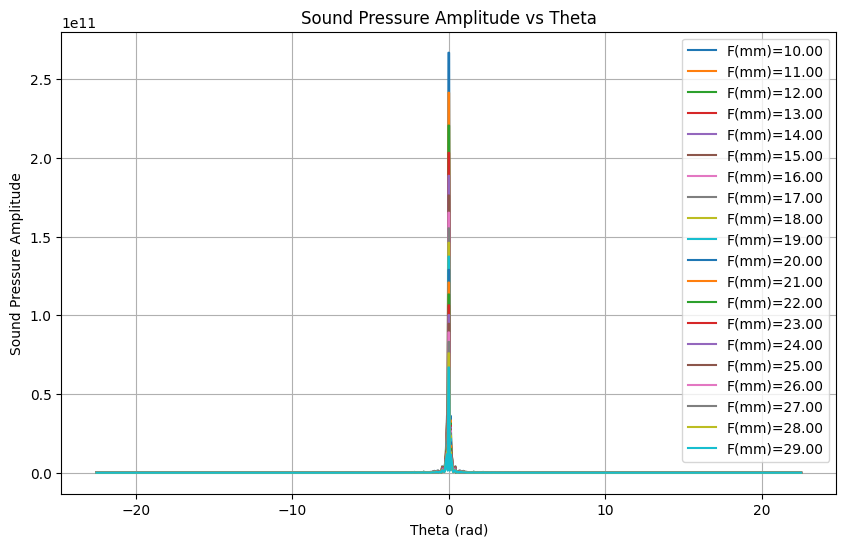

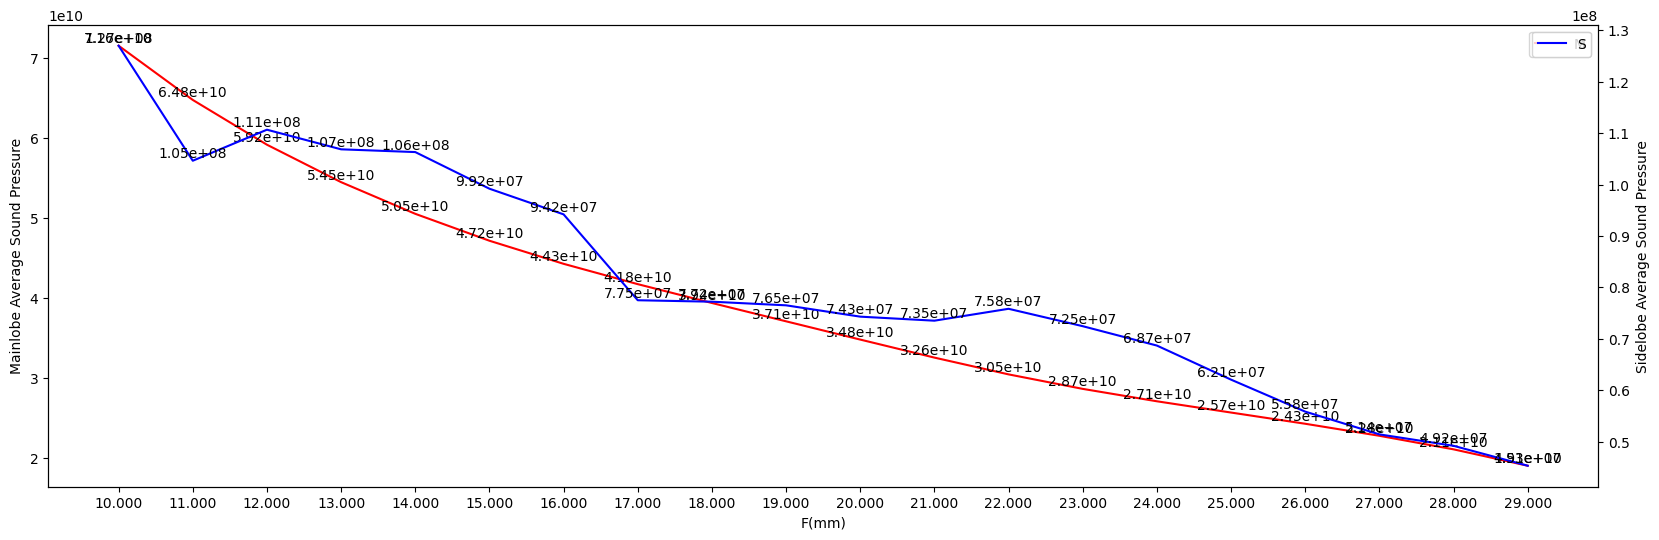

In [22]:
plt.figure(figsize=(10, 6))   

# 定义 delta_d 数组，范围从 0.1 * lambda_ 到 2 * lambda_
F_array = np.arange(10e-3, 30e-3, 1e-3)

a1_list = []
a2_list = []
mainlobe_avg_list = []
sidelobe_avg_list = []

# 开始绘制不同 delta_d 下的声压曲线
plt.figure(figsize=(10, 6))
# 设置图片清晰度
plt.rcParams['figure.dpi'] = 100

for F_d in F_array:
    a1_list = []
    a2_list = []
    # 调用函数计算圆环内外径
    a1_list, a2_list = calculate_annular_radii(R_max, m, delta_d)
    # 调用函数绘制圆环阵列
    # plot_annular_array(a1_list, a2_list, R_max, delta_d, colors)
    # 计算每个 theta 对应的声压幅值
    pressure_values = []
    for theta in theta_values:
        pressure = annular_array_pressure(a1_list, a2_list, F_d, F_d, m, theta, phi, t)
        pressure_amplitude = np.abs(pressure)
        pressure_values.append(pressure_amplitude)
    # 将 theta 从弧度转换为角度
    theta_values_deg = np.rad2deg(theta_values)
    # 绘制声压随 theta（角度）的变化曲线
    plt.plot(theta_values_deg, pressure_values, label='F(mm)={:.2f}'.format(F_d*1000))
    # 调用评价函数
    mainlobe_avg, sidelobe_avg = evaluate_sidelobe_mainlobe(pressure_values)
    mainlobe_avg_list.append(mainlobe_avg)
    sidelobe_avg_list.append(sidelobe_avg)
    print(f"主瓣平均声压: {mainlobe_avg:.6f}")
    print(f"旁瓣平均声压: {sidelobe_avg:.6f}")
plt.xlabel('Theta (rad)')
plt.ylabel('Sound Pressure Amplitude')
plt.title('Sound Pressure Amplitude vs Theta')
plt.legend()
plt.grid(True)
plt.show() 


# 绘制主瓣平均声压柱状图
x_pos = np.arange(len(F_array))
x_data = [f'{v:.3f}' for v in F_array*1e3]

fig,ax1 = plt.subplots()
fig.set_size_inches(20, 6)

ax1.set_xticks(x_pos, x_data)
ax1.plot(x_pos, mainlobe_avg_list,color='red')
for i, v in enumerate(mainlobe_avg_list):
    ax1.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')
ax1.set_xlabel('F(mm)')
ax1.set_ylabel('Mainlobe Average Sound Pressure')
ax1.legend('Mainlobe')

ax2 = ax1.twinx()
ax2.plot(x_pos, sidelobe_avg_list,color='blue')
for i, v in enumerate(sidelobe_avg_list):
    ax2.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')
ax2.set_ylabel('Sidelobe Average Sound Pressure')    
ax2.legend('Sidelobe')

plt.show()


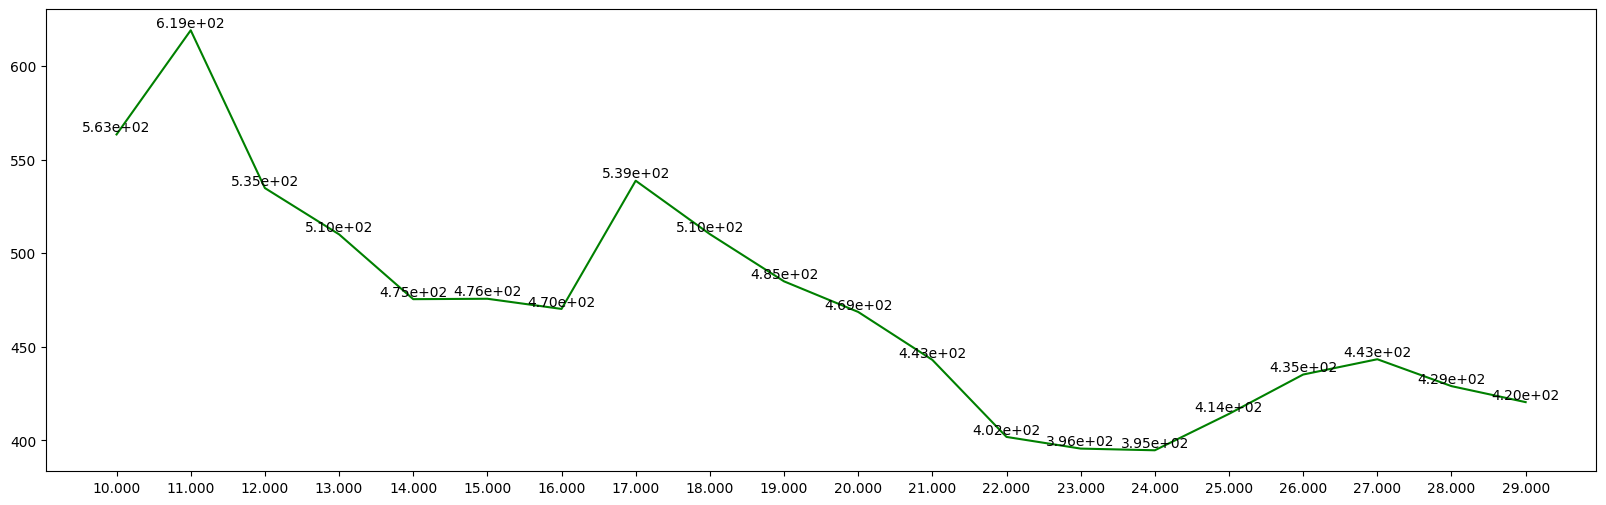

In [23]:
plt.figure(figsize=(20, 6))
plt.xticks(x_pos, x_data)
ratio = np.array(mainlobe_avg_list)/np.array(sidelobe_avg_list)
plt.plot(x_pos,ratio,color='green')
for i, v in enumerate(ratio):
    plt.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')
plt.show()

Gap:0.40[λ]


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

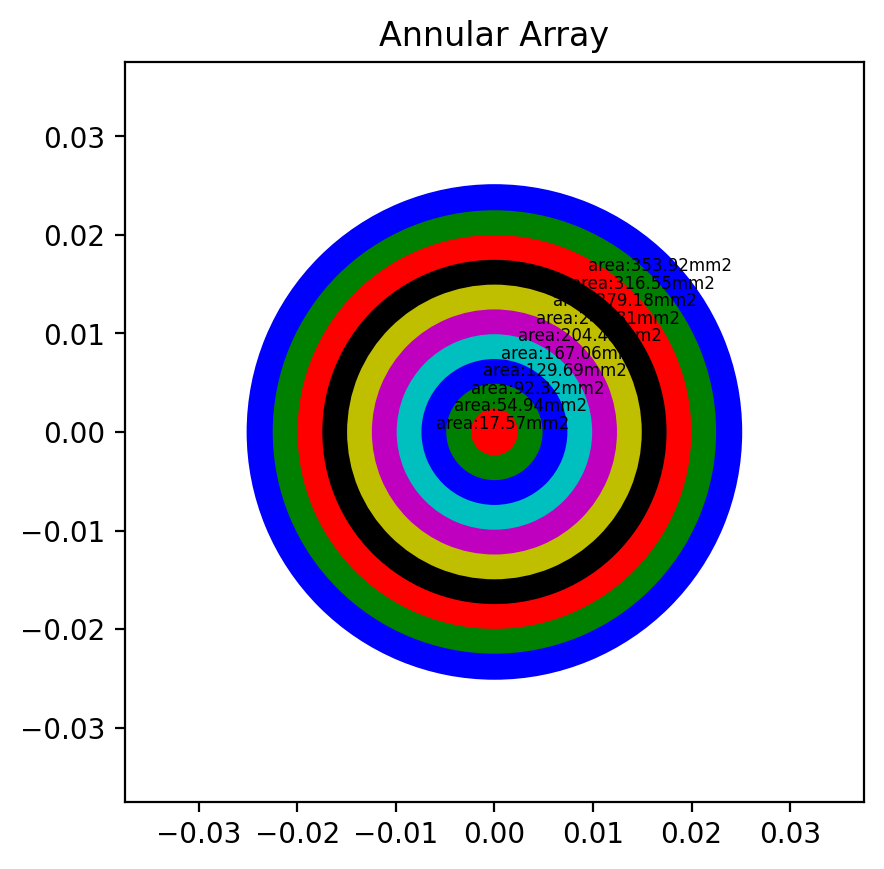

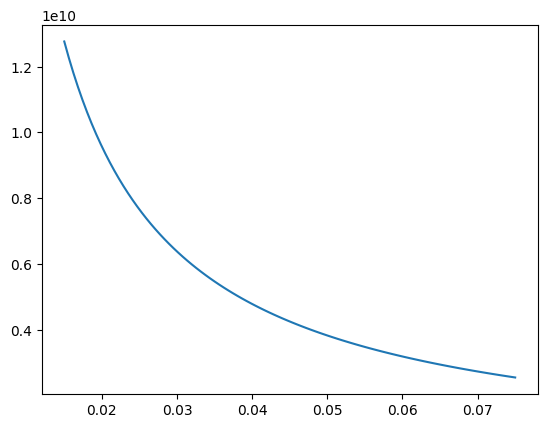

In [24]:
plt.figure(figsize=(10, 6))   

# 定义 delta_d 数组，范围从 0.1 * lambda_ 到 2 * lambda_
dis_array = np.linspace(F, 5*F, 100)

a1_list = []
a2_list = []

delta_d = lambda_ *2/5
# 开始绘制不同 delta_d 下的声压曲线
plt.figure(figsize=(10, 6))
# 设置图片清晰度
plt.rcParams['figure.dpi'] = 100
# 调用函数计算圆环内外径
a1_list, a2_list = calculate_annular_radii(R_max, m, delta_d)
# 调用函数绘制圆环阵列
plot_annular_array(a1_list, a2_list, R_max, delta_d, colors)
# 计算每个 theta 对应的声压幅值
pressure_values = []
    
for dis in dis_array:
    pressure = annular_array_pressure(a1_list, a2_list, F, dis, m, 0, 0, t)
    pressure_amplitude = np.abs(pressure)
    pressure_values.append(pressure_amplitude)
plt.plot(dis_array, pressure_values)
plt.show() 

Gap:0.70[λ]


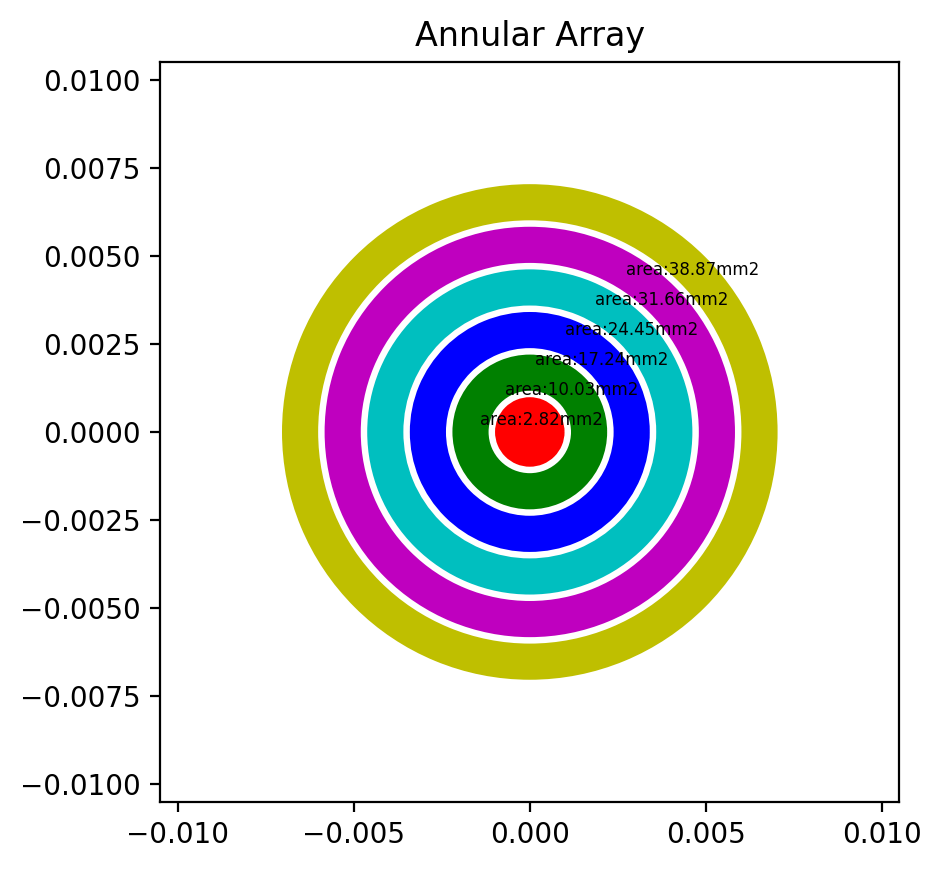

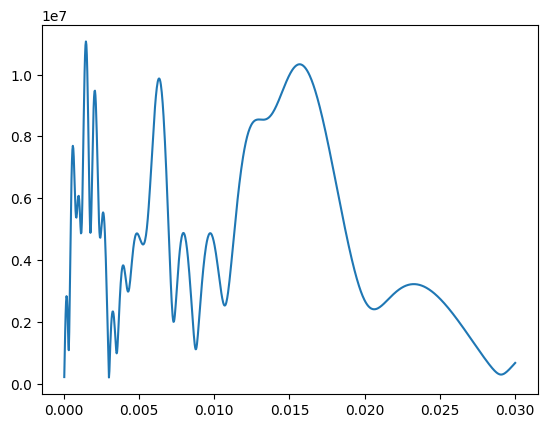

In [62]:
# 近场声压计算
# 计算相位延迟
F = 15e-3
R_max = 7e-3
m = 6
delta_d = 0.7 * lambda_

r_values = np.linspace(0.1*lambda_, F * 2,1000)  # 不同的距离 r
pressure_amplitudes = []

a1_list = np.zeros(m)
a2_list = np.zeros(m)

# 调用函数计算圆环内外径
a1_list, a2_list = calculate_annular_radii(R_max, m, delta_d)
# 调用函数绘制圆环阵列
plot_annular_array(a1_list, a2_list, R_max, delta_d, colors)
# 计算单个圆环的声压
# 定义声压公式，考虑分母为 0 的情况
def annular_array_pressure_axis(a1_list,a2_list, m, F, r, t):
    p_total = 0
    epsilon = 1e-20  # 一个极小值，用于避免分母为 0
    
    Rm_max = 2/3*(a2_list[m-1]**3 - a2_list[m-2]**3)/(a2_list[m-1]**2-a2_list[m-2]**2)
    # print("Rm_max: ", Rm_max)
    
    for i in range(m):
        a1 = a1_list[i]
        a2 = a2_list[i]
        R_m = 2/3*(a2**3 - a1**3)/(a2**2-a1**2)

        t_m = np.sqrt(Rm_max ** 2 + F ** 2) - np.sqrt(R_m ** 2 + F ** 2)
        t1 = np.sqrt(a1 ** 2 + r ** 2) 
        t2 = np.sqrt(a2 ** 2 + r ** 2)
        
        p = (rho0 * c* u) * np.exp(1j * w * t)* np.exp(-1j * k * t_m)* (np.exp(-1j * k * t1) - np.exp(-1j * k * t2) )
        p_total += p
            
    return p_total

pressure_amplitudes = []
for r in r_values:
    pressure = annular_array_pressure_axis(a1_list, a2_list, m, F, r ,0)
    pressure_amplitude = np.abs(pressure)
    pressure_amplitudes.append(pressure_amplitude)
plt.plot(r_values, pressure_amplitudes)
plt.show()


Gap:0.70[λ]


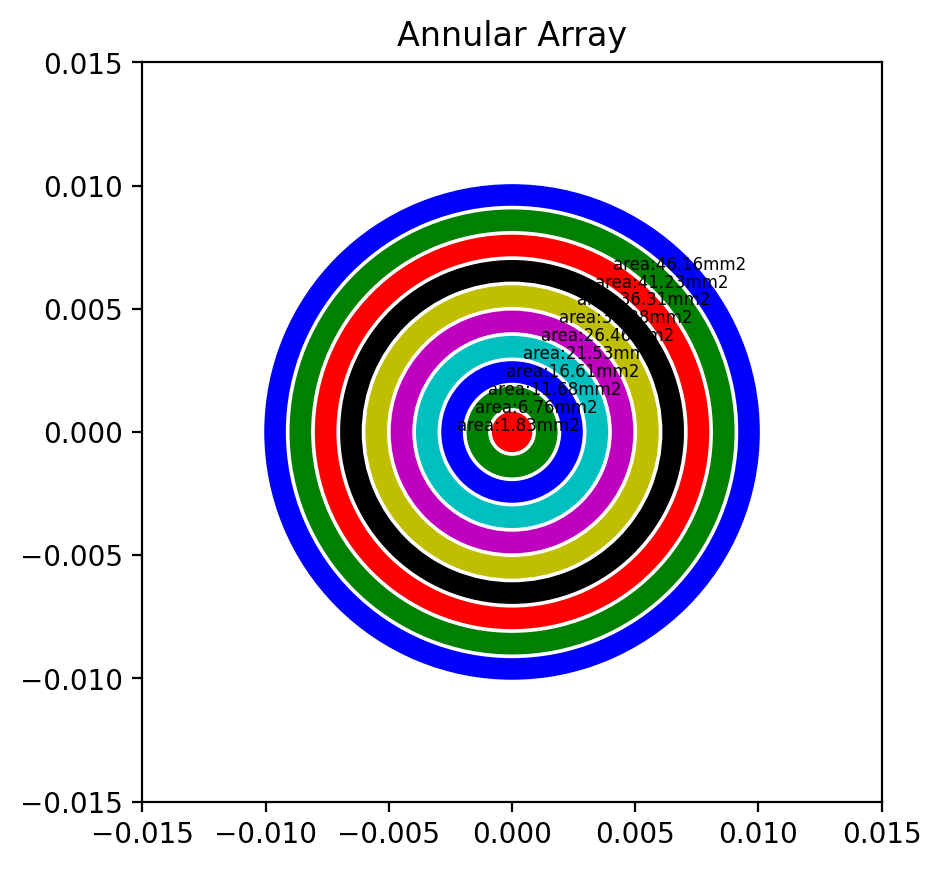

S: 1.8325351734856176e-06 Impedance: 473.24835645884014j
S: 6.757285999775933e-06 Impedance: 141.16853320678132j
S: 1.1682036826066255e-05 Impedance: 82.85398369267804j
S: 1.6606787652356576e-05 Impedance: 58.5154235779865j
S: 2.1531538478646883e-05 Impedance: 45.204231064878115j
S: 2.645628930493718e-05 Impedance: 36.819199146008735j
S: 3.13810401312275e-05 Impedance: 31.055241774103806j
S: 3.63057909575178e-05 Impedance: 26.8503731808046j
S: 4.12305417838082e-05 Impedance: 23.647737530179146j
S: 4.61552926100985e-05 Impedance: 21.127332236715514j


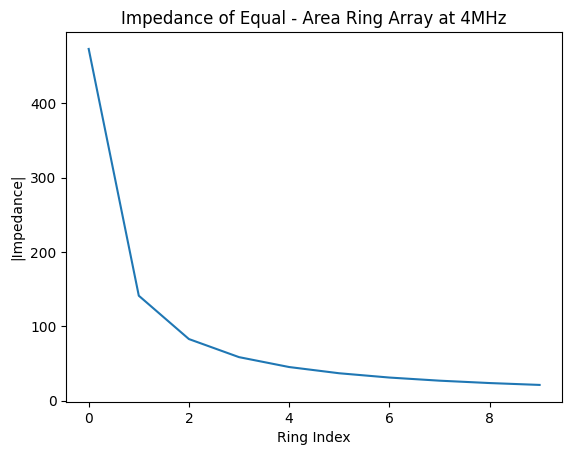

In [31]:
from mpl_toolkits.mplot3d import Axes3D

F = 20e-3
R_max = 10e-3
m = 10
delta_d = 0.7 * lambda_

# PZT - 3型陶瓷参数
h15 = -2.6 * 10 ** 9  # 压电应力常数
beta11s = 1.23 * 10 ** (-9)  # 恒应变下的介电隔离率
rho = 7500  # 材料密度
C55D = 2.94 * 10 ** 10  # 恒电位下的弹性刚度常数

# 计算剪切波传播速度
Ct = (C55D / rho) ** 0.5
# 根据经验公式或相关理论，假设厚度与波长相关，这里简单假设厚度为1/4波长（实际需根据具体理论模型调整）
l = lambda_ / 4  # 根据频率调整厚度

# 计算剪切波波数
kt = w / Ct

# 定义计算tau的函数
def calculate_tau(a1, a2):
    return (9 * (a1 + a2) ** 2 * (a1 ** 2 + a2 ** 2)) / (8 * (a1 ** 2 + a1 * a2 + a2 ** 2) ** 2)


# 定义计算k15t的函数
def calculate_k15t(tau):
    return h15 / np.sqrt(beta11s * C55D * tau)

# 定义计算阻抗的函数
def calculate_impedance(k15t, kt, l, omega, C0):
    return 1 / (1j * omega * C0) * (1 - (k15t ** 2) * (np.tan(kt * l / 2) / (kt * l / 2)))

impedance = np.zeros(m, dtype=complex)
a1_list = np.zeros(m)
a2_list = np.zeros(m)

# 调用函数计算圆环内外径
a1_list, a2_list = calculate_annular_radii(R_max, m, delta_d)
# 调用函数绘制圆环阵列
plot_annular_array(a1_list, a2_list, R_max, delta_d, colors)
# 计算每个圆环的阻抗
for i in range(m):
    # 计算每个圆环的面积作为振动横截面积S
    S = np.pi * (a2_list[i] ** 2 - a1_list[i] ** 2)
    # 根据公式计算C0
    C0 = S / (beta11s * l)
    tau = calculate_tau(a2_list[i], a1_list[i])
    k15t = calculate_k15t(tau)
    impedance[i] = calculate_impedance(k15t, kt, l, w, C0)
    print("S:", S, "Impedance:", impedance[i])
    
# 绘制圆环序号与阻抗模值的关系图
plt.plot(np.arange(0, m), np.abs(impedance))
plt.xlabel('Ring Index')
plt.ylabel('|Impedance|')
plt.title('Impedance of Equal - Area Ring Array at 4MHz')
plt.show()